# Creating a Basic Search Engine

The material we deal with here is from an Indonessian Website, so please don't panic if you don't understand it a single bit.

You'll also be learning about many more functions in Numpy and Pandas Libraries which we shall be using freely in the coming sections, so look up the documentation to get to know about their exact functions.

Before we get our hands dirty, let me give you the steps on how to implement this, and on each section, I will explain on how to build it. They are :

1) Preparing the documents

2)  Create a Term-Document Matrix with TF-IDF weighting

3)  Calculate the similarities between query and documents using Cosine Similarity

4)  Retrieve the articles that have the highest similarity on it.

##Retrieving the Documents

The first thing that we have to do is to retrieve the documents from the Internet. In this case, we can use web scraping to extract documents from a website. We will scrape documents from kompas.com on sport category, especially on the popular articles. Because of the documents are using HTML format, we initialize a BeautifulSoup object to parse the HTML file, so we can extract each element that we want much easier.

Here is the code that I used for extracting the documents and its explanations on each line : 


In [ ]:
import requests
from bs4 import BeautifulSoup
# Make a request to the website
r = requests.get('https://bola.kompas.com/')
# Create an object to parse the HTML format
soup = BeautifulSoup(r.content, 'html.parser')
# Retrieve all popular news links (Fig. 1)
link = []
for i in soup.find('div', {'class':'most__wrap'}).find_all('a'):
    i['href'] = i['href'] + '?page=all'
    link.append(i['href'])
# For each link, we retrieve paragraphs from it, combine each paragraph as one string, and save it to documents (Fig. 2)
documents = []
for i in link:
    # Make a request to the link
    r = requests.get(i)
  
    # Initialize BeautifulSoup object to parse the content 
    soup = BeautifulSoup(r.content, 'html.parser')
  
    # Retrieve all paragraphs and combine it as one
    sen = []
    for i in soup.find('div', {'class':'read__content'}).find_all('p'):
        sen.append(i.text)
  
    # Add the combined paragraphs to documents
    documents.append(' '.join(sen))

## Clean the Documents

Right after we extract the documents, we have to clean it, so our retrieval process becomes much easier. For each document, we have to remove all unnecessary words, numbers and punctuations, lowercase the word, and remove the doubled space. Here is the code for it : 

In [ ]:
import re
documents_clean = []
for d in documents:
    # Remove Unicode
    document_test = re.sub(r'[^\x00-\x7F]+', ' ', d)
    # Remove Mentions
    document_test = re.sub(r'@\w+', '', document_test)
    # Lowercase the document
    document_test = document_test.lower()
    # Remove punctuations
    document_test = re.sub(r'[%s]' % re.escape(string.punctuation), ' ', document_test)
    # Lowercase the numbers
    document_test = re.sub(r'[0-9]', '', document_test)
    # Remove the doubled space
    document_test = re.sub(r'\s{2,}', ' ', document_test)
    documents_clean.append(document_test)

Before Proceeding you should read more about the Statistical Tool : [TF-IDF](https://monkeylearn.com/blog/what-is-tf-idf/).

## Creating Term-Document Matrix with TF-IDF weighting

After each document is clean, it’s time to create a matrix. Thankfully, scikit-learn library has prepared for us the code of it, so we don’t have to implement it from scratch. The code looks like this :





In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Instantiate a TfidfVectorizer object
vectorizer = TfidfVectorizer()

# It fits the data and transform it as a vector
X = vectorizer.fit_transform(docs)

# Convert the X as transposed matrix
X = X.T.toarray()

# Create a DataFrame and set the vocabulary as the index
df = pd.DataFrame(X, index=vectorizer.get_feature_names())

The result (matrix) will become a representation of the documents. By using that, we can find the similarity between different documents based on the matrix. We could see the resulting matrix :

In [ ]:
print(df.head())
print(df.shape)

The matrix above is called as Term-Document Matrix. It consists of rows that represent by each token (term) from all documents, and the columns consist of the identifier of the document. Inside of the cell is the number of frequency of each word that is weighted by some number.

We will use the column vector, which is a vector that represents each document to calculate the similarity with a given query. We can call this vector as **embeddings**.

For calculating the cell value, the code uses the TF-IDF method to do this. TF-IDF (Term Frequency — Inverse Document Frequency) is a frequency of a word that is weighted by IDF. Let us see each one of them:


**Term Frequency (TF)** is a frequency of term (t) on document (d). The formula looks like this :

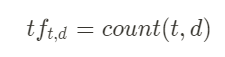

Beside of that, we can use a log with bases of 10 to calculate the TF, so the number becomes smaller, and the computation process becomes faster. Also, make sure to add one on it because we don’t want log 0 exist.

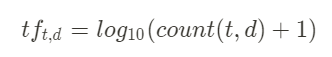

Then, there is the **Inverse Document Frequency (IDF)**. This formula will be used for calculating the rarity of the word in all documents. It will be used as weights for the TF. If a word is frequent, then the IDF will be smaller. In opposite, if the word is less frequent, then the IDF will be larger. The formula looks like this : 

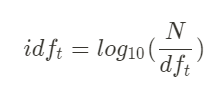

Recall the TF-IDF, we can see how does it affect the value on each cell. It will remove all the words that are frequently shown in documents but at the same time not important, such as and, or, even, actually, etc. Based on that, we use this as the value on each cell on our matrix.

## Calculate the similarity using cosine similarity

After we create the matrix, we can prepare our query to find articles based on the highest similarity between the document and the query. To calculate the similarity, we can use the cosine similarity formula to do this. It looks like this :

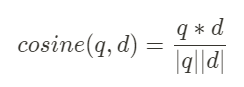

The formula calculates the dot product divided by the multiplication of the length on each vector. The value ranges from [1, 0], but in general, the cosine value ranges from [-1, 1]. Because there are no negative values on it, we can ignore the negative value because it never happens.


Now, we will implement the code to find similarities on documents based on a query. The first thing that we have to do is to transform the query as a vector on the matrix that we have. Then, we calculate the similarities between them. And finally, we retrieve all documents that have values above 0 in similarity. The code looks like this :

In [ ]:
def get_similar_articles(q, df):
  print("query:", q)
  print("Berikut artikel dengan nilai cosine similarity tertinggi: ")
  # Convert the query become a vector
  q = [q]
  q_vec = vectorizer.transform(q).toarray().reshape(df.shape[0],)
  sim = {}
  # Calculate the similarity
  for i in range(10):
    sim[i] = np.dot(df.loc[:, i].values, q_vec) / np.linalg.norm(df.loc[:, i]) * np.linalg.norm(q_vec)
  
  # Sort the values 
  sim_sorted = sorted(sim.items(), key=lambda x: x[1], reverse=True)
  # Print the articles and their similarity values
  for k, v in sim_sorted:
    if v != 0.0:
      print("Cosine Similarity:", v)
      print(docs[k])
      print()
# Add The Query
q1 = 'barcelona'
# Call the function
get_similar_articles(q1, df)

This notebook is adapted from [here](https://towardsdatascience.com/create-a-simple-search-engine-using-python-412587619ff5).